# Investigate Leading Indicators for Currencies

## 1] Helper Tools

In [1]:
import pandas as pd
import traceback
from datetime import timedelta

In [2]:
def merge_df(df_a, df_b, na='ffill', **kwargs):
	""" Merge data frames.
	"""
	try:
		# clean first
		dfa = df_a.copy()
		if 'date' not in dfa.columns:
			dfa = dfa.reset_index()
		dfa['date'] = pd.to_datetime(dfa['date'], format='%Y-%m-%d')
		# clean first
		dfb = df_b.copy()
		if 'date' not in dfb.columns:
			dfb = dfb.reset_index()
		dfb['date'] = pd.to_datetime(dfb['date'], format='%Y-%m-%d')
		# merge
		dfa = dfa.copy().set_index('date')
		dfb = dfb.copy().set_index('date')
		df = dfa.merge(dfb, **kwargs)
		# if DEBUG:
		# print('RLCOM: DEBUG: merge_df() | nan df=\n%s' % pd.isna(df.tail(10)))
		df = df.reset_index()
		df = df.sort_values(by='date').copy()
		if na == 'ffill':
			df = df.ffill()
		elif na == 'fillna0':
			df = df.fillna(0)
		elif 'drop' in na:
			df = df.dropna()
		return df.copy()
	except Exception as e:
		if isinstance(df_a, pd.core.frame.DataFrame) and isinstance(df_b, pd.core.frame.DataFrame):
			print(
				'WARNING Could not merge dataframe - \n' + str(df_a.tail(1)) +
				'\nwith dataframe - \n' + str(df_b.tail(1))
			)
		print(
			'ERROR: Exception for merge_df() ERR - \n' + str(traceback.format_exc()) +
			'\n' + str(e)
		)
		return df_a

def get_timeframe_by_dates(date_a, date_b, date_c):
	""" Determines the series period frequency by looking at their dates.
		 We use three dates just incase we start at a weekend.
		 INPUT: date from period 1, date from period 2, date from period 3
		 OUTPUT: monthly, quarterly, daily, weekly, annual
	"""
	a = pd.to_datetime(date_a).strftime('%Y-%m-%d')
	b = pd.to_datetime(date_b).strftime('%Y-%m-%d')
	c = pd.to_datetime(date_c).strftime('%Y-%m-%d')

	a_dt = pd.to_datetime(a)
	b_dt = pd.to_datetime(b)
	c_dt = pd.to_datetime(c)

	diff1 = abs(b_dt - a_dt)
	diff2 = abs(c_dt - b_dt)
	# print('get_timeframe_by_dates() | Difference = ' + str(diff))  # Debug
	two_weeks = timedelta(weeks=2)
	six_weeks = timedelta(weeks=6)
	one_day = timedelta(days=1)
	four_days = timedelta(days=4)
	eleven_days = timedelta(days=11)
	two_months = timedelta(weeks=8)
	four_months = timedelta(weeks=16)
	ten_months = timedelta(weeks=40)
	fourteen_months = timedelta(weeks=60)
	is_a_month = (
		(diff1 > two_weeks and diff1 < six_weeks) or (diff2 > two_weeks and diff2 < six_weeks)
	)
	is_a_quarter = (
		(diff1 > two_months and diff1 < four_months) or (diff2 > two_months and diff2 < four_months)
	)
	is_a_day = (diff1 == one_day) or (diff2 == one_day)
	is_a_week = (
		(diff1 > four_days and diff1 < eleven_days) or (diff2 > four_days and diff2 < eleven_days)
	)
	is_a_year = (
		(diff1 > ten_months and diff1 < fourteen_months) or
		(diff2 > ten_months and diff2 < fourteen_months)
	)
	if is_a_month:
		return 'monthly'
	elif is_a_quarter:
		return 'quarterly'
	elif is_a_day:
		return 'daily'
	elif is_a_week:
		return 'weekly'
	elif is_a_year:
		return 'yearly'
	else:
		return 'ERROR'

def add_quarterofyear_df(dfp):
	"""Calculates quarter of year and adds it to the input dataframe.
		INPUT: dataframe
		OUTPUT: enriched dataframe with quarter_of_year column
	"""
	df = dfp.copy()
	if 'date' not in df.columns:
		df = df.reset_index()
	df['date'] = pd.to_datetime(df['date'])
	df = df.set_index('date')
	df['quarter_of_year'] = pd.to_numeric(df.index.month / 3)
	df['quarter_of_year'] = df['quarter_of_year'].apply(
		lambda x: math.ceil(x)
	)
	return df.reset_index()


def add_monthofyear_df(dfp):
	"""Calculates month of year and adds it to the input dataframe.
		INPUT: dataframe
		OUTPUT: enriched dataframe with month_of_year column
	"""
	df = dfp.copy()
	if 'date' not in df.columns:
		df = df.reset_index()
	df['date'] = pd.to_datetime(df['date'])
	df['month_of_year'] = df['date'].apply(lambda x: x.month)
	return df


def add_dayofweek_df(dfp):
	"""Calculate day of week.
		INPUT: dataframe
		OUTPUT: enriched dataframe with day_of_week column Monday0 to Sunday6
	"""
	df = dfp.copy()
	if 'date' not in df.columns:
		df = df.reset_index()
	df['date'] = pd.to_datetime(df['date'])
	df['day_of_week'] = df['date'].apply(lambda x: x.dayofweek)
	return df


def add_weekofmonth_df(dfp):
	"""Calculate week of month.
		INPUT: dataframe
		OUTPUT: enriched dataframe with week_of_month column
	"""
	df = dfp.copy()
	if 'date' not in df.columns:
		df = df.reset_index()
	df['date'] = pd.to_datetime(df['date'])
	df = df.set_index('date')
	df['week_of_month'] = pd.to_numeric(df.index.day / 7)
	df['week_of_month'] = df['week_of_month'].apply(
		lambda x: math.ceil(x)
	)
	return df.reset_index()


In [3]:
def seasonality_row(value_list_df, time_frame):
	"""A helper method for get_seasonality function.
	"""
	df = value_list_df.copy()
	is_daily = (time_frame == 'daily')
	is_weekly = (time_frame == 'weekly')
	is_monthly = (time_frame == 'monthly')
	is_quarterly = (time_frame == 'quarterly')
	season_key = ''
	if is_daily:
		df = add_dayofweek_df(df)
		season_key = 'day_of_week'
	elif is_weekly:
		df = add_weekofmonth_df(df)
		season_key = 'week_of_month'
	elif is_monthly:
		df = add_monthofyear_df(df)
		season_key = 'month_of_year'
	elif is_quarterly:
		df = add_quarterofyear_df(df)
		season_key = 'quarter_of_year'
	else:
		print('Invalid time frame of ' + str(time_frame))
	df = df.reset_index()
	enriched = []
	for index, row in df.iterrows():
		date = row['date']
		if 'close' in row:
			open_val = row['open']
			high_val = row['high']
			low_val = row['low']
			close_val = row['close']
		elif 'value' in row:
			close_val = row['value']
		season_value = row[season_key]
		if 'close' in row:
			enriched.append(
				{
					'date': date,
					season_key: season_value,
					'open': open_val,
					'high': high_val,
					'low': low_val,
					'close': close_val
				}
			)
		elif 'value' in row:
			enriched.append(
				{
					'date': date,
					season_key: season_value,
					'value': close_val
				}
			)
	return pd.DataFrame(enriched)


def get_seasonality_calcs_tag(x):
	v = x[0]
	insig_pct = x[1]
	if v > insig_pct:
		return 1
	elif v < (abs(insig_pct) * -1):
		return -1
	elif v <= insig_pct and v >= (abs(insig_pct) * -1):
		return 0


def get_seasonality_calcs(
	skeys, growth_rate_df, season_key, seasonality_base_data_point,
	window_periods, insig_pct=None, method='avg'
):
	"""A helper method for get_seasonality function.
	"""
	c = 0
	if 'mondays' in skeys:
		c = -1
	new_skey = ['date']
	for k in skeys:
		if k != 'date':
			c = c + 1
			if method == 'avg':
				growth_rate_df[k] = growth_rate_df[
					growth_rate_df[season_key] == c
				][seasonality_base_data_point].rolling(window_periods).mean()
			elif method == 'count':
				bull_k = '%s_bullc' % (k, )
				bear_k = '%s_bearc' % (k, )
				insig_k = '%s_insigc' % (k, )
				new_skey.extend([bull_k, bear_k, insig_k])
				# count rises
				result = []
				for i in range(0, growth_rate_df['date'].count()):
					window = growth_rate_df.iloc[i - window_periods:i]
					if window['date'].count() == window_periods:
						rise_count = window[(
							window[season_key] == c
						) & (
							window[seasonality_base_data_point] > insig_pct
						)][seasonality_base_data_point].count()
						result.append({'date': window['date'].tail(1).values[0], bull_k: rise_count})
					else:
						result.append({})
				df_counts = pd.DataFrame(result)
				growth_rate_df = pd.merge(growth_rate_df, df_counts, on='date')
				# count falls
				result = []
				for i in range(0, growth_rate_df['date'].count()):
					window = growth_rate_df.iloc[i - window_periods:i]
					if window['date'].count() == window_periods:
						fall_count = window[(
							window[season_key] == c
						) & (
							window[seasonality_base_data_point] < (abs(insig_pct) * -1.0)
						)][seasonality_base_data_point].count()
						result.append({'date': window['date'].tail(1).values[0], bear_k: fall_count})
					else:
						result.append({})
				df_counts = pd.DataFrame(result)
				growth_rate_df = pd.merge(growth_rate_df, df_counts, on='date')
				# count insignificants
				result = []
				for i in range(0, growth_rate_df['date'].count()):
					window = growth_rate_df.iloc[i - window_periods:i]
					if window['date'].count() == window_periods:
						insig_count = window[(
							window[season_key] == c
						) & (
							window[seasonality_base_data_point] <= insig_pct
						) & (
							window[seasonality_base_data_point] >= (abs(insig_pct) * -1.0)
						)][seasonality_base_data_point].count()
						result.append({'date': window['date'].tail(1).values[0], insig_k: insig_count})
					else:
						result.append({})
				df_counts = pd.DataFrame(result)
				growth_rate_df = pd.merge(growth_rate_df, df_counts, on='date')
			elif method == 'tag':
				growth_rate_df[k] = growth_rate_df[
					growth_rate_df[season_key] == c
				][seasonality_base_data_point].apply(
					lambda x: get_seasonality_calcs_tag((x, insig_pct))
				)
			else:
				print('ERROR: No correct method found.')
				sys.exit(1)
	if new_skey.__len__() > 1:
		if method == 'tag':
			# Do not mess up the tagged probability space
			seasonality_df = growth_rate_df[new_skey]
		else:
			seasonality_df = growth_rate_df[new_skey].ffill()
		skeys = new_skey
	else:
		if method == 'tag':
			seasonality_df = growth_rate_df[skeys]
		else:
			seasonality_df = growth_rate_df[skeys].ffill()
	return skeys, seasonality_df


def get_seasonality(window_periods, df, insig_pct=None, method='avg', **kwargs):
	"""Calculates seasonality based on window period growth rate.
		The seasonality value is the rolling average seasonality of that frequency group.
		INPUT: window_periods, dataframe - OHLC or value column data frame
													- all data will be converted to a growth rate
				 insig_pct - Configure this to return a count of bears and bulls
							  - use insig_pct to exclude growth rates that are too small
							  - example - insig_pct=0.05 - 5 percent gr will be counted as too small
		OUTPUT: dataframe with seasonality columns
				  - For normal seasonality returning average growth rate per seasonal period
						** we return a pattern of columns as per below
						- mondays, tuesdays etc. for daily time frames
						- week_1, week_2 etc. for weekly time frames
						- month_1, month_2 etc. for monthly time frames
						- quarter_1, quarter_2 etc. for quarterly time frames
				  - For bear, bull, insig counts for odds calcs per seasonal period
						** we return a pattern of columns as per below
						- mondays_bearc, mondays_bullc, mondays_insigc etc. for daily time frames
						- week_1_bearc, week_2_bearc etc. for weekly time frames
						- month_1_bullc, month_2_bullc etc. for monthly time frames
						- quarter_1_insigc, quarter_2_insigc etc. for quarterly time frames
	"""
	value_list_df = df.copy()
	if value_list_df.empty or value_list_df['date'].count() < 4:
		return pd.DataFrame()
	# is_ohlc = ('close' in value_list_df.columns)
	# is_econometric = ('value' in value_list_df.columns)
	value_list_df['date'] = pd.to_datetime(value_list_df['date'])
	value_list_df = value_list_df.sort_values(by='date')
	if 'gr' not in value_list_df.columns:
		value_list_df = get_growth_rate(value_list_df)
	value_list_df['value'] = value_list_df['gr']
	value_list_df = value_list_df[['date', 'value']].copy()
	date_a = value_list_df['date'].iloc[3]
	date_b = value_list_df['date'].iloc[4]
	date_c = value_list_df['date'].iloc[5]

	time_frame = get_timeframe_by_dates(date_a, date_b, date_c)
	is_daily = (time_frame == 'daily')
	is_weekly = (time_frame == 'weekly')
	is_monthly = (time_frame == 'monthly')
	is_quarterly = (time_frame == 'quarterly')
	# is_annual = (time_frame == 'annual')
	season_key = ''
	if is_daily:
		grouped_seasonality = [
			seasonality_row(g, time_frame) for n, g in value_list_df.set_index(
				'date'
			).groupby(
				pd.Grouper(freq='W')
			)
		]
		season_key = 'day_of_week'
	elif is_weekly:
		grouped_seasonality = [
			seasonality_row(g, time_frame) for n, g in value_list_df.set_index(
				'date'
			).groupby(
				pd.Grouper(freq='Y')
			)
		]
		season_key = 'week_of_month'
	elif is_monthly:
		grouped_seasonality = [
			seasonality_row(g, time_frame) for n, g in value_list_df.set_index(
				'date'
			).groupby(
				pd.Grouper(freq='Y')
			)
		]
		season_key = 'month_of_year'
	elif is_quarterly:
		grouped_seasonality = [
			seasonality_row(g, time_frame) for n, g in value_list_df.set_index(
				'date'
			).groupby(
				pd.Grouper(freq='Y')
			)
		]
		season_key = 'quarter_of_year'
	else:
		print(
			'WARNING: get_seasonality() - Could not detect window time frame - result - ' +
			str(time_frame)
		)
		return []
	metric_list = []
	seasonality_base_data_point = ''
	for group in grouped_seasonality:
		for index, row in group.iterrows():
			metric_list.append(
				{
					'date': row['date'],
					season_key: row[season_key],
					'value': float(row['value'])
				}
			)
	growth_rate_df = pd.DataFrame(metric_list)
	# print(
	#    'growth_rate_df 4 samples: ' + str(growth_rate_df[:4])
	# )
	keys_daily = [
		'date', 'mondays', 'tuesdays', 'wednesdays', 'thursdays', 'fridays', 'saturdays', 'sundays'
	]
	keys_weekly = ['date']
	keys_weekly.extend(['week_%s' % (x, ) for x in range(1, 6)])
	keys_monthly = ['date']
	keys_monthly.extend(['month_%s' % (x, ) for x in range(1, 13)])
	keys_quarterly = ['date']
	keys_quarterly.extend(['quarter_%s' % (x, ) for x in range(1, 5)])
	seasonality_base_data_point = 'value'
	seasonality_option_keys = []
	if is_daily:
		skeys = keys_daily
		skeys, seasonality_df = get_seasonality_calcs(
			skeys, growth_rate_df, season_key, seasonality_base_data_point,
			window_periods, insig_pct=insig_pct, method=method
		)
		seasonality_df = add_dayofweek_df(seasonality_df)
		seasonality_option_keys = ['date', 'day_of_week']
	elif is_weekly:
		skeys = keys_weekly
		skeys, seasonality_df = get_seasonality_calcs(
			skeys, growth_rate_df, season_key, seasonality_base_data_point,
			window_periods, insig_pct=insig_pct, method=method
		)
		seasonality_df = add_weekofmonth_df(seasonality_df)
		seasonality_option_keys = ['date', 'week_of_month']
	elif is_monthly:
		skeys = keys_monthly
		skeys, seasonality_df = get_seasonality_calcs(
			skeys, growth_rate_df, season_key, seasonality_base_data_point,
			window_periods, insig_pct=insig_pct, method=method
		)
		seasonality_df = add_monthofyear_df(seasonality_df)
		seasonality_option_keys = ['date', 'month_of_year']
	elif is_quarterly:
		skeys = keys_quarterly
		skeys, seasonality_df = get_seasonality_calcs(
			skeys, growth_rate_df, season_key, seasonality_base_data_point,
			window_periods, insig_pct=insig_pct, method=method
		)
		seasonality_df = add_quarterofyear_df(seasonality_df)
		seasonality_option_keys = ['date', 'quarter_of_year']
	for row in list(kwargs.keys()):
		if kwargs[row] is True:
			if row not in seasonality_option_keys:
				seasonality_option_keys.append(row)
	if seasonality_option_keys.__len__() == 2:
		for k in skeys:
			if k not in seasonality_option_keys:
				seasonality_option_keys.append(k)
	df = seasonality_df[seasonality_option_keys].reset_index().copy()
	del df['index']
	return df

In [4]:
def clean_col_helper(v):
    x = v
    if type(x) == str:
        x = x.replace(",", "")
        if x != '':
            return float(x)
        else:
            return np.nan

def clean_value_df_cols(df_in, col):
    df = df_in.copy()
    df = df.dropna()
    df[col] = df[col].apply(lambda x: clean_col_helper(x))
    df = df.dropna()
    df[col] = df[col].astype(float)
    return df

,close
date,
2024-03-05,0.6481
2024-03-04,0.6511
2024-03-03,0.6527
2024-03-01,0.6523
2024-02-29,0.6495
2024-02-28,0.6496
2024-02-27,0.6543
2024-02-26,0.6540
2024-02-23,0.6560


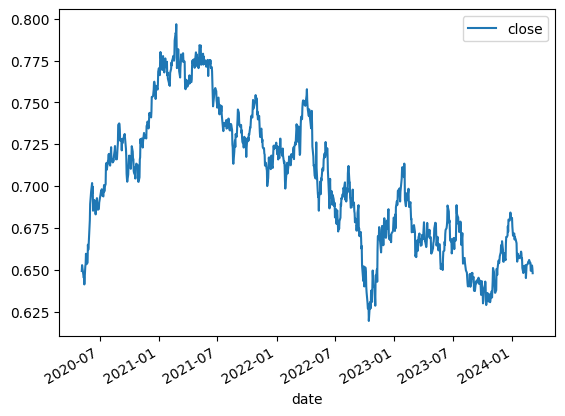

In [5]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 30

# CSV from investing dot com
df = pd.read_csv('db/AUD_USD_Historical_Data.csv')
# Clean the data frame
del df['Vol.']
df['date'] = pd.to_datetime(df['Date'])
df = df.set_index('date')
df['close'] = df['Price']
del df['Date']
del df['Price']
del df['Open']
del df['High']
del df['Low']
del df['Change %']
df.head(1000)[['close']].plot()
df.head(10)

## 2] Turning Seasonal Odds into a Leading Indicator

<Axes: xlabel='date'>

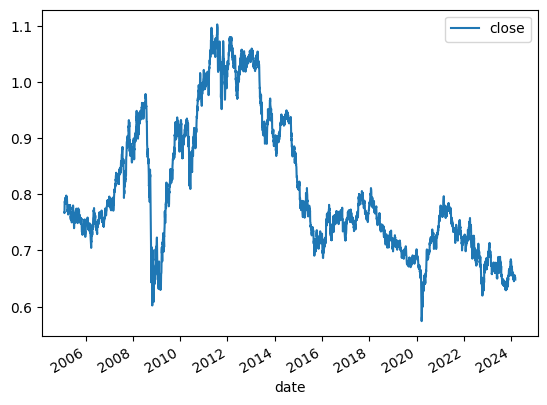

In [6]:
df = df.sort_values(by=['date'], ascending=True)
df['gr'] = df['close'].pct_change()
df
df[['close']].plot()

<Axes: xlabel='date'>

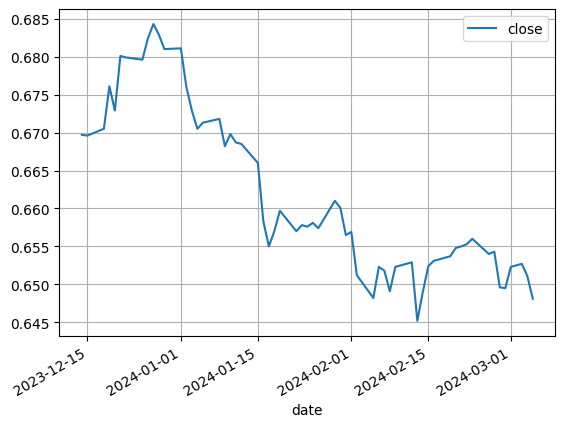

In [7]:
df[['close']].tail(60).plot(grid=True)

In [8]:
df_seas = df.copy().reset_index()
df_seas

,date,close,gr
0,2005-02-07,0.7676,NaN
1,2005-02-08,0.7666,-0.001303
2,2005-02-09,0.7709,0.005609
3,2005-02-10,0.7832,0.015955
4,2005-02-11,0.7858,0.003320
...,...,...,...
4973,2024-02-29,0.6495,-0.000154
4974,2024-03-01,0.6523,0.004311
4975,2024-03-03,0.6527,0.000613
4976,2024-03-04,0.6511,-0.002451


In [9]:
window_periods = 60
df_seas = get_seasonality(window_periods, df_seas, insig_pct=0.0001, method='count')
pd.options.display.max_columns = 30
df_seas.tail(30)

,date,day_of_week,mondays_bullc,mondays_bearc,mondays_insigc,tuesdays_bullc,tuesdays_bearc,tuesdays_insigc,wednesdays_bullc,wednesdays_bearc,wednesdays_insigc,thursdays_bullc,thursdays_bearc,thursdays_insigc,fridays_bullc,fridays_bearc,fridays_insigc,saturdays_bullc,saturdays_bearc,saturdays_insigc,sundays_bullc,sundays_bearc,sundays_insigc
3688,2023-12-27,2,8.0,4.0,0.0,7.0,5.0,0.0,3.0,9.0,0.0,7.0,5.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3689,2023-12-28,3,8.0,4.0,0.0,7.0,5.0,0.0,3.0,9.0,0.0,6.0,6.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3690,2023-12-29,4,8.0,4.0,0.0,7.0,5.0,0.0,3.0,9.0,0.0,6.0,6.0,0.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3691,2024-01-01,0,8.0,4.0,0.0,7.0,5.0,0.0,3.0,9.0,0.0,6.0,6.0,0.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3692,2024-01-02,1,8.0,4.0,0.0,6.0,6.0,0.0,3.0,9.0,0.0,6.0,6.0,0.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3693,2024-01-03,2,8.0,4.0,0.0,6.0,6.0,0.0,3.0,9.0,0.0,6.0,6.0,0.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3694,2024-01-04,3,8.0,4.0,0.0,6.0,6.0,0.0,3.0,9.0,0.0,6.0,6.0,0.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3695,2024-01-05,4,8.0,4.0,0.0,6.0,6.0,0.0,3.0,9.0,0.0,6.0,6.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3696,2024-01-08,0,8.0,4.0,0.0,6.0,6.0,0.0,3.0,9.0,0.0,6.0,6.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3697,2024-01-09,1,8.0,4.0,0.0,5.0,7.0,0.0,3.0,9.0,0.0,6.0,6.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Most of the above odds are close to 1:1 random, except for wednesdays yielding a strong bear signal with an odds of 9:3.

Now that we have the seasonal odds we can convert it to a log index.

In [11]:
# Build a Bear Log Odds Leading Indicator
import math
season_key = 'day_of_week'
window_periods = 1
result = []
for i in range(0, df_seas['date'].count()):
    window = df_seas.iloc[i - window_periods:i]
    if window['date'].count() == window_periods:
        rise_count = 0
        fall_count = 0
        modds = 0
        lodds = 0
        season = window[season_key].tail(1).values[0] 
        if season == 0:
            rise_count = window[(
                window[season_key] == 0
            )]['mondays_bullc'].values[0]
            fall_count = window[(
                window[season_key] == 0
            )]['mondays_bearc'].values[0]
        if season == 1:
            rise_count = window[(
                window[season_key] == 1
            )]['tuesdays_bullc'].values[0]
            fall_count = window[(
                window[season_key] == 1
            )]['tuesdays_bearc'].values[0]
        if season == 2:
            rise_count = window[(
                window[season_key] == 2
            )]['wednesdays_bullc'].values[0]
            fall_count = window[(
                window[season_key] == 2
            )]['wednesdays_bearc'].values[0]
        if season == 3:
            rise_count = window[(
                window[season_key] == 3
            )]['thursdays_bullc'].values[0]
            fall_count = window[(
                window[season_key] == 3
            )]['thursdays_bearc'].values[0]
        if season == 4:
            rise_count = window[(
                window[season_key] == 4
            )]['fridays_bullc'].values[0]
            fall_count = window[(
                window[season_key] == 4
            )]['fridays_bearc'].values[0]
        if fall_count == 0:
            fall_count = 0.1
        if rise_count == 0:
            rise_count = 0.1
        modds = float(fall_count) / rise_count
        lodds = math.log(modds)
        result.append(
            {
                'date': window['date'].tail(1).values[0],
                'season' : season,
                'fall': fall_count,
                'rise': rise_count,
                'metric_odds': modds,
                'log_odds': lodds
            }
        )
    else:
        result.append({})


,season,fall,rise,metric_odds,log_odds
date,,,,,
2023-12-26,1.0,5.0,7.0,0.714286,-0.336472
2023-12-27,2.0,9.0,3.0,3.000000,1.098612
2023-12-28,3.0,6.0,6.0,1.000000,0.000000
2023-12-29,4.0,7.0,5.0,1.400000,0.336472
2024-01-01,0.0,4.0,8.0,0.500000,-0.693147
2024-01-02,1.0,6.0,6.0,1.000000,0.000000
2024-01-03,2.0,9.0,3.0,3.000000,1.098612
2024-01-04,3.0,6.0,6.0,1.000000,0.000000
2024-01-05,4.0,6.0,6.0,1.000000,0.000000


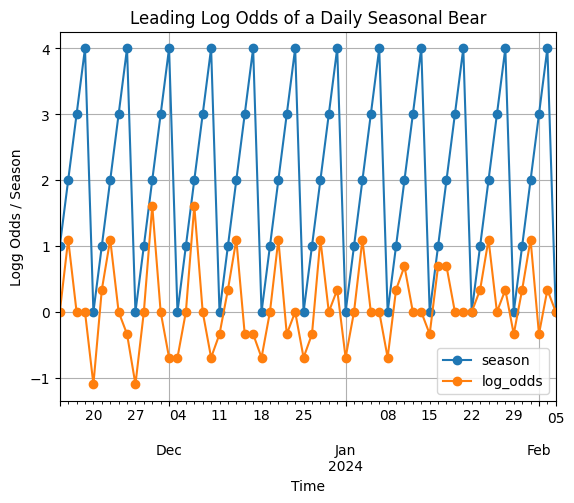

In [18]:
df_counts = pd.DataFrame(result)
df_graph = df_counts.copy()
df_graph = df_graph.set_index('date')
df_graph[['season', 'log_odds']].tail(60).plot(
    marker='o',
    grid=True,
    title=(
        'Leading Log Odds of a Daily Seasonal Bear'
    ),
    ylabel='Logg Odds / Season',
    xlabel='Time'
)
df_graph.tail(30)

Above log 1 means a strong bear, below log -1 means a strong bull or it is insignificant.

<Axes: title={'center': 'AUDUSD Price'}, xlabel='date'>

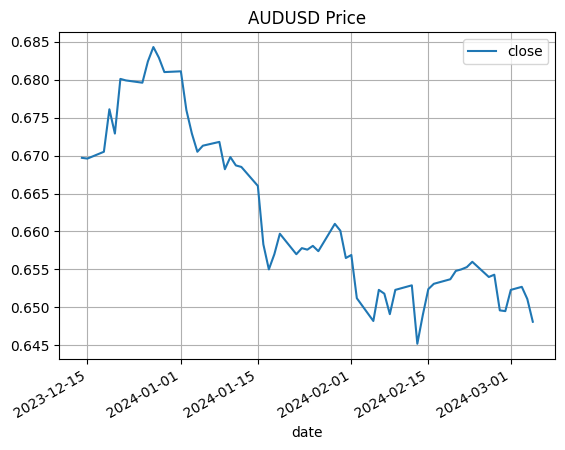

In [21]:
# AUDUSD Price
df[['close']].tail(60).plot(grid=True, title='AUDUSD Price')

It is important to note that Season Monday is 0, and Friday is 4 on the leading indicator graph.

By looking at the last 60 days we can see that there is a consistent high probability bear breaching the log 1 threshold on a wednesday(2). The graph shows that you probably should short sell AUDUSD since there are more seasonal bears than bulls.

The AUDUSD currency pair falling shows Australia's demand for importing United States goods and services. The high conviction odds of a sell on a Wednesday maybe an indicator of market makers making bulk purchases.

This notebook demonstrates how to turn a seasonaly table into an actionable single indicator. This notebook is only for resume purposes. Use the code and errors at your own risk, or just hire me! I'm sure i can adapt this to your needs and have it well tested. 